In [1]:
import os
import json
import matplotlib.pyplot as plt 
import matplotlib.image as image 
import numpy as np
import pandas as pd
import albumentations as A
import albumentations.pytorch
import cv2
import math

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

import sys
sys.path.append('../')
from utils.dataset import *
# from train import PapsClsModel


/home/beomgon/anaconda3/envs/deepspeed/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

RED_COLOR = (255, 0, 0) # Red
BLUE_COLOR = (0, 0, 255) # Blue
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, boxes, color=RED_COLOR, thickness=3):
    """Visualizes a single bounding box on the image"""
    bbox = boxes[:4]
    if len(boxes) ==5 and boxes[4] ==1 :
        color = (0, 255, 0)
    x_min, y_min, w, h = list(map(int, bbox))
#     print(bbox)
#     x_min, y_min, x_max, y_max = list(map(round, bbox))
#     print((int(x_min), int(y_min)), (int(x_max), int(y_max)))

    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_min+w), int(y_min+h)), color=color, thickness=thickness)
    return img

def visualize(image, g_boxes, p_boxes=[]):
    img = image.copy()
    print(img.shape)
#     img = image.clone().detach()
    for bbox in (g_boxes):
#         print(bbox)
        img = visualize_bbox(img, bbox)
    for bbox in (p_boxes):
#         print(bbox)
        img = visualize_bbox(img, bbox, color=BLUE_COLOR, thickness=5)    
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(img)

In [3]:
train_df = pd.read_csv( '../lbp_data/train.csv')

In [4]:
train_df.shape

(16569, 13)

In [5]:
train_df.head()

,ID,file_name,task,bbox,xmin,ymin,w,h,label,label_id,occluded,des,cell_type
0,0,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[1539, 199, 139, 211]",1539,199,139,211,C,Candida,0,NaN,ASC-US
1,1,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[1337, 102, 256, 136]",1337,102,256,136,AS,ASC-US,0,NaN,ASC-US
2,2,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[220, 619, 166, 169]",220,619,166,169,AS,ASC-US,0,NaN,ASC-US
3,3,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[658, 1747, 191, 166]",658,1747,191,166,AS,ASC-US,0,NaN,ASC-US
4,4,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[1571, 365, 136, 146]",1571,365,136,146,AS,ASC-US,0,NaN,ASC-US


In [6]:
# train_df.label.value_counts()

In [7]:
len(train_df.label_id.unique())

9

In [8]:
train_df.shape

(16569, 13)

In [9]:
# train_dataset = PapsDataset(train_df, defaultpath='../lbp_data/', transform=train_transforms)

In [10]:
train_dataset = ContraPapsDataset(train_df, defaultpath='../lbp_data/')

(15869, 13)


In [11]:
# image1, label = next(iter(train_dataset))
# image1, image2 = next(iter(train_dataset))

In [12]:
train_df.head()

,ID,file_name,task,bbox,xmin,ymin,w,h,label,label_id,occluded,des,cell_type
0,0,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[1539, 199, 139, 211]",1539,199,139,211,5,Candida,0,NaN,ASC-US
1,1,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[1337, 102, 256, 136]",1337,102,256,136,0,ASC-US,0,NaN,ASC-US
2,2,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[220, 619, 166, 169]",220,619,166,169,0,ASC-US,0,NaN,ASC-US
3,3,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[658, 1747, 191, 166]",658,1747,191,166,0,ASC-US,0,NaN,ASC-US
4,4,patch_images/2021.01.14/LBC424-20210111(1)/LBC...,[AS6] LBC424,"[1571, 365, 136, 146]",1571,365,136,146,0,ASC-US,0,NaN,ASC-US


In [13]:
# plt.imshow(image1)

In [14]:
# plt.imshow(image2)

In [15]:
# path

In [16]:
# bboxes = train_df[train_df['file_name'] == path][['xmin', 'ymin', 'w', 'h']].values
# bboxes

In [17]:
bboxes = np.array([[1300,  100,  300,  180]])

In [18]:
# img = cv2.imread('../lbp_data/'+path)

In [19]:
# visualize(img, bboxes)

In [20]:
# xmin, ymin, w, h = bboxes[0]

# image = img[ymin:ymin+h,xmin:xmin+w,:]
# plt.imshow(image)

In [21]:
# image.shape

In [22]:
# xmin, ymin, w, h = bboxes[0]

# image = img[xmin:xmin+w, ymin:ymin+h,:]
# plt.imshow(image)

In [23]:
train_loader =  torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)


In [24]:
images1, images2, label = next(iter(train_loader))

In [25]:
images1.shape

torch.Size([16, 3, 224, 224])

In [26]:
# images2.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


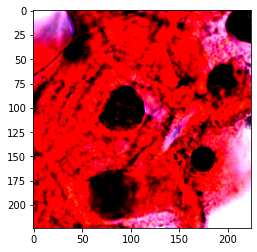

In [27]:
plt.imshow(images1[9].permute(1,2,0))

In [28]:
# images1[6].permute(1,2,0)[160:180,160:180,:]

In [30]:
# plt.imshow(images1[0])

In [32]:
images = torch.cat([images1, images2], dim=0)
images.shape

torch.Size([32, 3, 224, 224])